# Recommender Systems Challenge, 2023/2024 @ PoliMi

# Introduction

## Problem Description
The application domain is book recommendation. The datasets contain interactions of users with books, in particular, if the user attributed to the book a rating of at least 4. The main goal of the competition is to discover which items (books) a user will interact with.

The datasets includes around 600k interactions, 13k users, 22k items (books).
The training-test split is done via random holdout, 80% training, 20% test.
The goal is to recommend a list of 10 potentially relevant items for each user.


## Datasets
All files are comma-separated (columns are separated with ',' ).

- **data_train.csv**:
Contains the training set, describing implicit preferences expressed by the users.
    - **user_id** : identifier of the user
    - **item_id** : identifier of the item (Book)
    - **data** : "1.0" if the user liked the book attributing it a rating of at least 4.


- **data_target_users_test.csv**:
Contains the ids of the users that should appear in your submission file.
The submission file should contain all and only these users.

- **sample_submission.csv**:
A sample submission file in the correct format: [user_id],[ordered list of recommended items].
Be careful with the spaces and be sure to recommend the correct number of items to every user.

# Requirements

The working environment and the required libraries are defined here.

In [1]:
# Import libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy.sparse as sps # creation of sparse matrix
import matplotlib.pyplot as pyplot # plot

from tqdm import tqdm

from scipy.stats import uniform, loguniform
import optuna as op
import xgboost as xgb
from xgboost import XGBRanker

In [2]:
%load_ext Cython

# Data Preprocessing

In [3]:
# Handle the input file
input_file = open('Input/data_train.csv', 'r')
type(input_file)

_io.TextIOWrapper

In [4]:
# Build the dataframe from the input file
input_df = pd.read_csv(
    filepath_or_buffer=input_file,
    dtype={0:int, 1:int, 2:int},
    names=['user_id','item_id','data'],
    header=0
)

input_df.shape

(478730, 3)

In [5]:
# Show the first rows of the dataframe
input_df.head(n=10)

,user_id,item_id,data
0,1,7,1
1,1,15,1
2,1,16,1
3,1,133,1
4,1,161,1
5,1,187,1
6,1,205,1
7,1,222,1
8,1,237,1
9,1,354,1


In [6]:
# mapped_id, original_id = pd.factorize(input_df["user_id"].unique())
# user_original_ID_to_index = pd.Series(mapped_id, index=original_id)

# print("Unique UserID in the URM are {}".format(len(original_id)))

# mapped_id, original_id = pd.factorize(input_df["item_id"].unique())
# item_original_ID_to_index = pd.Series(mapped_id, index=original_id)

# print("Unique ItemID in the URM are {}".format(len(original_id)))

# input_df["user_id"] = input_df["user_id"].map(user_original_ID_to_index)
# input_df["item_id"] = input_df["item_id"].map(item_original_ID_to_index)

In [7]:
input_df

,user_id,item_id,data
0,1,7,1
1,1,15,1
2,1,16,1
3,1,133,1
4,1,161,1
...,...,...,...
478725,13024,13605,1
478726,13024,13823,1
478727,13024,15122,1
478728,13024,18185,1


# Matrix Conversion

In [8]:
arr_users = input_df["user_id"].unique()
arr_items = input_df["item_id"].unique()

max_user = input_df["user_id"].max()
max_item = input_df["item_id"].max()

# n_users = len(arr_users)
# n_items = len(arr_items)

# n_users = max_user
# n_items = max_item

# Evaluation of the recommender

In [9]:
# Import Evaluators
from Evaluation.Evaluator import EvaluatorHoldout
from sklearn.model_selection import train_test_split
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

In [10]:
seed = 42

In [11]:
(user_ids_training_validation, user_ids_test,
 item_ids_training_validation, item_ids_test,
 ratings_training_validation, ratings_test) = train_test_split(input_df.user_id,
                                                    input_df.item_id,
                                                    input_df.data,
                                                    test_size=0.15,
                                                    shuffle=True,
                                                    random_state=seed)

(user_ids_training, user_ids_validation,
 item_ids_training, item_ids_validation,
 ratings_training, ratings_validation) = train_test_split(user_ids_training_validation,
                                                          item_ids_training_validation,
                                                          ratings_training_validation,
                                                          test_size=0.15,
                                                          shuffle=True,
                                                          random_state=seed)

In [12]:
URM_all = sps.csr_matrix((input_df.data, (input_df.user_id, input_df.item_id)),
                            shape=(13025, 22348)
                        )

URM_train = sps.csr_matrix((ratings_training, (user_ids_training, item_ids_training)),
                            shape=(13025, 22348)
                          )

URM_validation = sps.csr_matrix((ratings_validation, (user_ids_validation, item_ids_validation)),
                            shape=(13025, 22348)
                               )

URM_train_validation = sps.csr_matrix((ratings_training_validation, (user_ids_training_validation, item_ids_training_validation)),
                            shape=(13025, 22348)
                                     )

URM_test = sps.csr_matrix((ratings_test, (user_ids_test, item_ids_test)),
                            shape=(13025, 22348)
                         )


In [13]:
# URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = train_test_split)
# URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = train_test_split)

In [14]:
URM_all.shape, URM_train.shape, URM_validation.shape

((13025, 22348), (13025, 22348), (13025, 22348))

In [15]:
URM_train_validation.shape, URM_test.shape

((13025, 22348), (13025, 22348))

In [16]:
from Evaluation.Evaluator import EvaluatorHoldout

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 3447 (26.5%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 3123 (24.0%) Users that have less than 1 test interactions


## Best Recommenders after tuning

In [17]:
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender
slime_train = MultiThreadSLIM_SLIMElasticNetRecommender(URM_train)
slime_train.fit(l1_ratio=0.0702, alpha=0.000722, topK=692)

SLIMElasticNetRecommender: URM Detected 716 ( 5.5%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 291 ( 1.3%) items with no interactions.


100%|███████████████████████████████████████████████████████████████████████████████▉| 22344/22348 [02:07<00:00, 175.55it/s]


In [18]:
slime_train_val = MultiThreadSLIM_SLIMElasticNetRecommender(URM_train_validation)
slime_train_val.fit(l1_ratio=0.0702, alpha=0.000722, topK=692)

SLIMElasticNetRecommender: URM Detected 541 ( 4.2%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 200 ( 0.9%) items with no interactions.


100%|███████████████████████████████████████████████████████████████████████████████▉| 22344/22348 [02:52<00:00, 129.30it/s]


In [19]:
from Recommenders.KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender
from Recommenders.Similarity.Compute_Similarity import Compute_Similarity
sim1 = Compute_Similarity(URM_train, shrink = 0, topK = 5, similarity = 'cosine').compute_similarity()
sim2 = Compute_Similarity(URM_train, shrink = 0.5, topK = 65, similarity = 'cosine').compute_similarity()
itemhybrid_train = ItemKNNSimilarityHybridRecommender(URM_train, sim1, sim2)
itemhybrid_train.fit(topK = 70, alpha = 0.65)

Similarity column 22348 (100.0%), 12524.80 column/sec. Elapsed time 1.78 sec
Similarity column 22348 (100.0%), 12401.64 column/sec. Elapsed time 1.80 sec
ItemKNNSimilarityHybridRecommender: URM Detected 716 ( 5.5%) users with no interactions.
ItemKNNSimilarityHybridRecommender: URM Detected 291 ( 1.3%) items with no interactions.


In [20]:
sim1_val = Compute_Similarity(URM_train_validation, shrink = 0, topK = 5, similarity = 'cosine').compute_similarity()
sim2_val = Compute_Similarity(URM_train_validation, shrink = 0.5, topK = 65, similarity = 'cosine').compute_similarity()
itemhybrid_train_val = ItemKNNSimilarityHybridRecommender(URM_train_validation, sim1_val, sim2_val)
itemhybrid_train_val.fit(topK = 70, alpha = 0.65)

Similarity column 22348 (100.0%), 11640.67 column/sec. Elapsed time 1.92 sec
Similarity column 22348 (100.0%), 11572.01 column/sec. Elapsed time 1.93 sec
ItemKNNSimilarityHybridRecommender: URM Detected 541 ( 4.2%) users with no interactions.
ItemKNNSimilarityHybridRecommender: URM Detected 200 ( 0.9%) items with no interactions.


In [21]:
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
rp3beta_train = RP3betaRecommender(URM_train)
rp3beta_train.fit(topK=25, alpha=0.253519, beta=0.209538, implicit=True, normalize_similarity=True)

RP3betaRecommender: URM Detected 716 ( 5.5%) users with no interactions.
RP3betaRecommender: URM Detected 291 ( 1.3%) items with no interactions.
RP3betaRecommender: Similarity column 22348 (100.0%), 6649.92 column/sec. Elapsed time 3.36 sec


In [22]:
rp3beta_train_val = RP3betaRecommender(URM_train_validation)
rp3beta_train_val.fit(topK=25, alpha=0.253519, beta=0.209538, implicit=True, normalize_similarity=True)

RP3betaRecommender: URM Detected 541 ( 4.2%) users with no interactions.
RP3betaRecommender: URM Detected 200 ( 0.9%) items with no interactions.
RP3betaRecommender: Similarity column 22348 (100.0%), 6351.66 column/sec. Elapsed time 3.52 sec


In [23]:
from Recommenders.ScoresHybridRecommender3 import ScoresHybridRecommender3
recommender_train = ScoresHybridRecommender3(URM_train, slime_train, itemhybrid_train, rp3beta_train)
recommender_train.fit(alpha=0.7, beta=0.05)

ScoresHybridRecommender3: URM Detected 716 ( 5.5%) users with no interactions.
ScoresHybridRecommender3: URM Detected 291 ( 1.3%) items with no interactions.


In [24]:
recommender_train_val = ScoresHybridRecommender3(URM_train_validation, slime_train_val, itemhybrid_train_val, rp3beta_train_val)
recommender_train_val.fit(alpha=0.7, beta=0.05)

ScoresHybridRecommender3: URM Detected 541 ( 4.2%) users with no interactions.
ScoresHybridRecommender3: URM Detected 200 ( 0.9%) items with no interactions.


In [25]:
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
itemknncf_train = ItemKNNCFRecommender(URM_train)
itemknncf_train.fit(shrink=15.47563, topK=12, similarity='dice')

ItemKNNCFRecommender: URM Detected 716 ( 5.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 291 ( 1.3%) items with no interactions.
Similarity column 22348 (100.0%), 12727.90 column/sec. Elapsed time 1.76 sec


In [26]:
itemknncf_train_val = ItemKNNCFRecommender(URM_train_validation)
itemknncf_train_val.fit(shrink=15.47563, topK=12, similarity='dice')

ItemKNNCFRecommender: URM Detected 541 ( 4.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 200 ( 0.9%) items with no interactions.
Similarity column 22348 (100.0%), 11863.76 column/sec. Elapsed time 1.88 sec


In [27]:
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
p3alpha_train = P3alphaRecommender(URM_train)
p3alpha_train.fit(topK=35, alpha=0.210046, implicit=True, normalize_similarity=True)

P3alphaRecommender: URM Detected 716 ( 5.5%) users with no interactions.
P3alphaRecommender: URM Detected 291 ( 1.3%) items with no interactions.
P3alphaRecommender: Similarity column 22348 (100.0%), 7045.93 column/sec. Elapsed time 3.17 sec


In [28]:
p3alpha_train_val = P3alphaRecommender(URM_train_validation)
p3alpha_train_val.fit(topK=35, alpha=0.210046, implicit=True, normalize_similarity=True)

P3alphaRecommender: URM Detected 541 ( 4.2%) users with no interactions.
P3alphaRecommender: URM Detected 200 ( 0.9%) items with no interactions.
P3alphaRecommender: Similarity column 22348 (100.0%), 6494.87 column/sec. Elapsed time 3.44 sec


In [29]:
from Recommenders.EASE_R.EASE_R_Recommender import EASE_R_Recommender
ease_train = EASE_R_Recommender(URM_train)
ease_train.fit(topK=29, l2_norm=19)

EASE_R_Recommender: URM Detected 716 ( 5.5%) users with no interactions.
EASE_R_Recommender: URM Detected 291 ( 1.3%) items with no interactions.
EASE_R_Recommender: Fitting model... 
EASE_R_Recommender: Fitting model... done in 1.50 min


In [30]:
ease_train_val = EASE_R_Recommender(URM_train_validation)
ease_train_val.fit(topK=29, l2_norm=19)

EASE_R_Recommender: URM Detected 541 ( 4.2%) users with no interactions.
EASE_R_Recommender: URM Detected 200 ( 0.9%) items with no interactions.
EASE_R_Recommender: Fitting model... 
EASE_R_Recommender: Fitting model... done in 1.50 min


In [31]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
userknncf_train = UserKNNCFRecommender(URM_train)
userknncf_train.fit(shrink=1.432797, topK=329, feature_weighting="TF-IDF")

UserKNNCFRecommender: URM Detected 716 ( 5.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 291 ( 1.3%) items with no interactions.
Similarity column 13025 (100.0%), 10833.56 column/sec. Elapsed time 1.20 sec


In [32]:
userknncf_train_val = UserKNNCFRecommender(URM_train_validation)
userknncf_train_val.fit(shrink=1.432797, topK=329, feature_weighting="TF-IDF")

UserKNNCFRecommender: URM Detected 541 ( 4.2%) users with no interactions.
UserKNNCFRecommender: URM Detected 200 ( 0.9%) items with no interactions.
Similarity column 13025 (100.0%), 10569.99 column/sec. Elapsed time 1.23 sec


In [33]:
evaluator_test.evaluateRecommender(recommender_train_val)

EvaluatorHoldout: Processed 9902 (100.0%) in 7.56 sec. Users per second: 1309


(       PRECISION PRECISION_RECALL_MIN_DEN    RECALL       MAP MAP_MIN_DEN  \
 cutoff                                                                      
 10      0.083619                 0.163903  0.146715  0.042224    0.082216   
 
              MRR      NDCG        F1  HIT_RATE ARHR_ALL_HITS  ...  \
 cutoff                                                        ...   
 10      0.249553  0.144202  0.106525  0.486366      0.321452  ...   
 
        COVERAGE_USER COVERAGE_USER_HIT USERS_IN_GT DIVERSITY_GINI  \
 cutoff                                                              
 10           0.76023           0.36975     0.76023       0.087613   
 
        SHANNON_ENTROPY RATIO_DIVERSITY_HERFINDAHL RATIO_DIVERSITY_GINI  \
 cutoff                                                                   
 10           10.875003                   0.998833             0.251788   
 
        RATIO_SHANNON_ENTROPY RATIO_AVERAGE_POPULARITY RATIO_NOVELTY  
 cutoff                                   

## XGBoost

In [34]:
candidate_generator_recommender = recommender_train

In [35]:
n_users, n_items = URM_train.shape

training_dataframe = pd.DataFrame(index=range(0,n_users), columns = ["item_id"])
training_dataframe.index.name='user_id'

In [36]:
training_dataframe

,item_id
user_id,
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
13020,NaN
13021,NaN
13022,NaN


In [37]:
cutoff = 30

for user_id in tqdm(range(n_users)):    
    recommendations = candidate_generator_recommender.recommend(user_id, cutoff = cutoff)
    training_dataframe.loc[user_id, "item_id"] = recommendations

100%|███████████████████████████████████████████████████████████████████████████████| 13025/13025 [00:10<00:00, 1294.41it/s]


In [38]:
training_dataframe

,item_id
user_id,
0,"[14906, 14925, 14919, 14922, 14921, 14924, 149..."
1,"[36, 101, 123, 694, 1057, 1422, 506, 1546, 592..."
2,"[1095, 47, 50, 196, 1522, 11, 112, 28, 3164, 1..."
3,"[59, 648, 9, 259, 536, 307, 125, 584, 4252, 41..."
4,"[249, 28, 27, 50, 42, 187, 639, 136, 128, 846,..."
...,...
13020,"[6450, 6452, 6747, 6198, 6451, 6749, 7395, 119..."
13021,"[6425, 304, 66, 6179, 7369, 6749, 6451, 7395, ..."
13022,"[1411, 1446, 1668, 809, 1674, 508, 277, 265, 4..."


In [39]:
training_dataframe = training_dataframe.explode("item_id")
training_dataframe

,item_id
user_id,
0,14906
0,14925
0,14919
0,14922
0,14921
...,...
13024,7771
13024,11956
13024,6283


In [40]:
URM_validation_coo = sps.coo_matrix(URM_validation)

correct_recommendations = pd.DataFrame({"user_id": URM_validation_coo.row,
                                        "item_id": URM_validation_coo.col})
correct_recommendations

,user_id,item_id
0,1,161
1,1,187
2,1,237
3,1,429
4,1,1005
...,...,...
61033,13024,4678
61034,13024,4999
61035,13024,6283
61036,13024,10904


In [41]:
training_dataframe = pd.merge(training_dataframe, correct_recommendations, on=['user_id','item_id'], how='left', indicator='Exist')

training_dataframe["Label"] = training_dataframe["Exist"] == "both"
training_dataframe.drop(columns = ['Exist'], inplace=True)
training_dataframe

,user_id,item_id,Label
0,0,14906,False
1,0,14925,False
2,0,14919,False
3,0,14922,False
4,0,14921,False
...,...,...,...
390745,13024,7771,False
390746,13024,11956,False
390747,13024,6283,True
390748,13024,20014,False


In [42]:
other_algorithms = {
    "Hybrid": recommender_train,
    "ItemKNNCF": itemknncf_train,
    "P3alpha": p3alpha_train,
    "RP3beta": rp3beta_train,
    "SLIM-E": slime_train,
    "EASE_R": ease_train,
    "UserKNNCF": userknncf_train,
    "ItemHybrid": itemhybrid_train,
}

In [43]:
training_dataframe = training_dataframe.set_index('user_id')

for user_id in tqdm(range(n_users)):  
    for rec_label, rec_instance in other_algorithms.items():
        
        item_list = training_dataframe.loc[user_id, "item_id"].values.tolist()
        
        all_item_scores = rec_instance._compute_item_score([user_id], items_to_compute = item_list)

        training_dataframe.loc[user_id, rec_label] = all_item_scores[0, item_list] 

training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "user_id"})
training_dataframe

100%|████████████████████████████████████████████████████████████████████████████████| 13025/13025 [00:45<00:00, 284.18it/s]


,user_id,item_id,Label,Hybrid,ItemKNNCF,P3alpha,RP3beta,SLIM-E,EASE_R,UserKNNCF,ItemHybrid
0,0,14906,False,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,14925,False,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0,14919,False,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0,14922,False,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0,14921,False,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
390745,13024,7771,False,0.188733,0.492098,0.169697,0.250989,0.096870,0.125774,3.146688,1.163542
390746,13024,11956,False,0.188157,0.308597,0.049334,0.103673,0.163499,0.096997,1.989396,0.955799
390747,13024,6283,True,0.185106,0.501469,0.065051,0.116858,0.164557,0.126300,3.091875,0.814031
390748,13024,20014,False,0.183420,0.266715,0.044726,0.118529,0.132133,0.106642,1.188300,1.225892


In [44]:
item_popularity = np.ediff1d(sps.csc_matrix(URM_train).indptr)
training_dataframe['item_popularity'] = item_popularity[training_dataframe["item_id"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_train).indptr)
training_dataframe['user_profile_len'] = user_popularity[training_dataframe["user_id"].values.astype(int)]

training_dataframe

,user_id,item_id,Label,Hybrid,ItemKNNCF,P3alpha,RP3beta,SLIM-E,EASE_R,UserKNNCF,ItemHybrid,item_popularity,user_profile_len
0,0,14906,False,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5,0
1,0,14925,False,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8,0
2,0,14919,False,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7,0
3,0,14922,False,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3,0
4,0,14921,False,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
390745,13024,7771,False,0.188733,0.492098,0.169697,0.250989,0.096870,0.125774,3.146688,1.163542,10,51
390746,13024,11956,False,0.188157,0.308597,0.049334,0.103673,0.163499,0.096997,1.989396,0.955799,6,51
390747,13024,6283,True,0.185106,0.501469,0.065051,0.116858,0.164557,0.126300,3.091875,0.814031,15,51
390748,13024,20014,False,0.183420,0.266715,0.044726,0.118529,0.132133,0.106642,1.188300,1.225892,4,51


## After adding features

In [45]:
# training_dataframe = training_dataframe.set_index('user_id')
# training_dataframe = training_dataframe.reset_index()
# training_dataframe = training_dataframe.rename(columns = {"index": 'user_id'})
# training_dataframe

In [46]:
training_dataframe = training_dataframe.sort_values("user_id").reset_index()
training_dataframe.drop(columns = ['index'], inplace=True)
training_dataframe

,user_id,item_id,Label,Hybrid,ItemKNNCF,P3alpha,RP3beta,SLIM-E,EASE_R,UserKNNCF,ItemHybrid,item_popularity,user_profile_len
0,0,14906,False,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5,0
1,0,14926,False,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4,0
2,0,14917,False,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8,0
3,0,14908,False,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,0
4,0,14888,False,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
390745,13024,4082,False,0.432749,0.702923,0.311602,0.331469,0.363772,0.228297,5.897381,1.904831,23,51
390746,13024,4076,False,0.497724,0.643031,0.380900,0.422565,0.414469,0.233989,8.006481,2.039078,22,51
390747,13024,20014,False,0.183420,0.266715,0.044726,0.118529,0.132133,0.106642,1.188300,1.225892,4,51
390748,13024,7473,False,0.306947,0.736429,0.197687,0.311280,0.205518,0.187019,3.027545,1.705277,12,51


In [47]:
groups = training_dataframe.groupby("user_id").size().values
groups

array([30, 30, 30, ..., 30, 30, 30], dtype=int64)

In [48]:
y_train = training_dataframe["Label"]
X_train_xgb = training_dataframe.drop(columns=["Label"])

In [49]:
X_train_xgb["user_id"] = X_train_xgb["user_id"].astype("category")
X_train_xgb["item_id"] = X_train_xgb["item_id"].astype("category")

In [72]:
n_estimators = 300
learning_rate = 0.2
reg_alpha = 30
reg_lambda = 0.1
max_depth = 3
max_leaves = 0
grow_policy = "depthwise"
objective = "pairwise"
booster = "gbtree"
use_user_profile = False
random_seed = 42

colsample_bytree = 0.7
gamma = 5
min_child_weight = 5.0


XGB_model = XGBRanker(objective='rank:{}'.format(objective),
                      n_estimators = int(n_estimators),
                      random_state = random_seed,
                      learning_rate = learning_rate,
                      reg_alpha = reg_alpha,
                      reg_lambda = reg_lambda,
                      max_depth = int(max_depth),
                      max_leaves = int(max_leaves),
                      grow_policy = grow_policy,
                      verbosity = 0, # 2 if self.verbose else 0,
                      booster = booster,
                      enable_categorical = True,
                      colsample_bytree = colsample_bytree,
                      gamma = gamma,
                      min_child_weight = min_child_weight,
                      tree_method = "hist",  # Supported tree methods are `gpu_hist`, `approx`, and `hist`.
                      )

In [73]:
XGB_model.fit(X_train_xgb,
          y_train,
          group=groups,
          verbose=True)


XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=0.7,
          device=None, early_stopping_rounds=None, enable_categorical=True,
          eval_metric=None, feature_types=None, gamma=5,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints=None, learning_rate=0.2, max_bin=None,
          max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
          max_depth=3, max_leaves=0, min_child_weight=5.0, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=300,
          n_jobs=None, num_parallel_tree=None, objective='rank:pairwise', ...)

In [74]:
%matplotlib inline
from xgboost import plot_importance

<Axes: title={'center': 'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

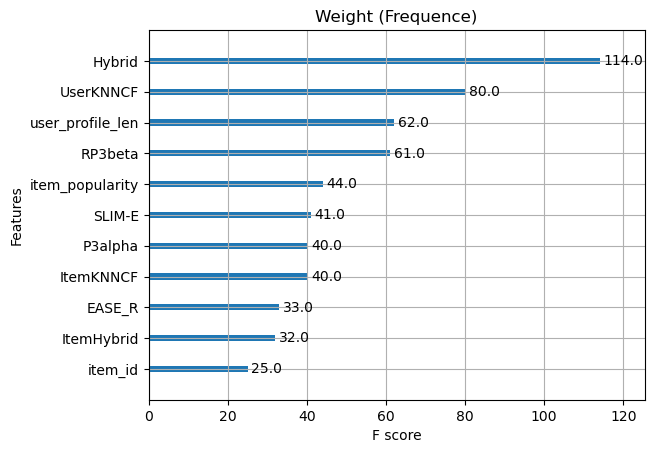

In [75]:
plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)')

## Build test dataframe

In [54]:
users_to_recommend = np.unique(URM_test.tocoo().row)

user_recommendations_items = []
user_recommendations_user_id = []

for id in tqdm(users_to_recommend):
    # getting the recommendations
    recommendations = recommender_train_val.recommend(user_id_array=id, remove_seen_flag=True, cutoff=cutoff)
    
    user_recommendations_items.extend(recommendations)
    user_recommendations_user_id.extend([id]*len(recommendations))
    
test_dataframe = pd.DataFrame({"user_id":user_recommendations_user_id, "item_id":user_recommendations_items})
test_dataframe

100%|█████████████████████████████████████████████████████████████████████████████████| 9902/9902 [00:07<00:00, 1287.18it/s]


,user_id,item_id
0,1,36
1,1,101
2,1,123
3,1,1422
4,1,254
...,...,...
297055,13024,2196
297056,13024,13593
297057,13024,11956
297058,13024,181


In [55]:
other_algorithms_train_validation = {
    "Hybrid": recommender_train_val,
    "ItemKNNCF": itemknncf_train_val,
    "P3alpha": p3alpha_train_val,
    "RP3beta": rp3beta_train_val,
    "SLIM-E": slime_train_val,
    "EASE_R": ease_train_val,
    "UserKNNCF": userknncf_train_val,
    "ItemHybrid": itemhybrid_train_val,
}

In [56]:
test_dataframe = test_dataframe.set_index('user_id')

for user_id in tqdm(users_to_recommend):       
    for rec_label, rec_instance in other_algorithms_train_validation.items():
        
        item_list = test_dataframe.loc[user_id, "item_id"].values.tolist()
        
        all_item_scores = rec_instance._compute_item_score([user_id], items_to_compute = item_list)

        test_dataframe.loc[user_id, rec_label] = all_item_scores[0, item_list] 

test_dataframe = test_dataframe.reset_index()
test_dataframe = test_dataframe.rename(columns = {"index": "user_id"})
test_dataframe

100%|██████████████████████████████████████████████████████████████████████████████████| 9902/9902 [00:36<00:00, 271.75it/s]


,user_id,item_id,Hybrid,ItemKNNCF,P3alpha,RP3beta,SLIM-E,EASE_R,UserKNNCF,ItemHybrid
0,1,36,0.672995,0.321683,0.607547,0.679385,0.639363,0.593756,21.290291,1.111884
1,1,101,0.589907,0.498082,0.373896,0.586864,0.550339,0.534240,19.700144,1.159062
2,1,123,0.260332,0.115880,0.146091,0.130480,0.301250,0.224135,3.698099,0.336736
3,1,1422,0.236253,0.273885,0.071360,0.110474,0.254512,0.199755,1.512125,0.609515
4,1,254,0.221222,0.264794,0.112332,0.137951,0.231102,0.211118,2.326481,0.499258
...,...,...,...,...,...,...,...,...,...,...
297055,13024,2196,0.234125,0.497641,0.116096,0.205520,0.205749,0.149621,7.112954,0.774408
297056,13024,13593,0.212264,0.509938,0.087018,0.182238,0.131707,0.135075,2.340214,1.490197
297057,13024,11956,0.207470,0.631166,0.025652,0.097227,0.163339,0.087020,2.830958,1.376519
297058,13024,181,0.200274,0.215831,0.054784,0.138673,0.197252,0.189733,1.548169,0.550587


In [57]:
item_popularity = np.ediff1d(sps.csc_matrix(URM_train_validation).indptr)

test_dataframe['item_popularity'] = item_popularity[test_dataframe["item_id"].values.astype(int)]
test_dataframe

,user_id,item_id,Hybrid,ItemKNNCF,P3alpha,RP3beta,SLIM-E,EASE_R,UserKNNCF,ItemHybrid,item_popularity
0,1,36,0.672995,0.321683,0.607547,0.679385,0.639363,0.593756,21.290291,1.111884,617
1,1,101,0.589907,0.498082,0.373896,0.586864,0.550339,0.534240,19.700144,1.159062,354
2,1,123,0.260332,0.115880,0.146091,0.130480,0.301250,0.224135,3.698099,0.336736,173
3,1,1422,0.236253,0.273885,0.071360,0.110474,0.254512,0.199755,1.512125,0.609515,63
4,1,254,0.221222,0.264794,0.112332,0.137951,0.231102,0.211118,2.326481,0.499258,239
...,...,...,...,...,...,...,...,...,...,...,...
297055,13024,2196,0.234125,0.497641,0.116096,0.205520,0.205749,0.149621,7.112954,0.774408,37
297056,13024,13593,0.212264,0.509938,0.087018,0.182238,0.131707,0.135075,2.340214,1.490197,4
297057,13024,11956,0.207470,0.631166,0.025652,0.097227,0.163339,0.087020,2.830958,1.376519,8
297058,13024,181,0.200274,0.215831,0.054784,0.138673,0.197252,0.189733,1.548169,0.550587,197


In [58]:
user_popularity = np.ediff1d(sps.csr_matrix(URM_train_validation).indptr)

test_dataframe['user_profile_len'] = user_popularity[test_dataframe["user_id"].values.astype(int)]
test_dataframe

,user_id,item_id,Hybrid,ItemKNNCF,P3alpha,RP3beta,SLIM-E,EASE_R,UserKNNCF,ItemHybrid,item_popularity,user_profile_len
0,1,36,0.672995,0.321683,0.607547,0.679385,0.639363,0.593756,21.290291,1.111884,617,38
1,1,101,0.589907,0.498082,0.373896,0.586864,0.550339,0.534240,19.700144,1.159062,354,38
2,1,123,0.260332,0.115880,0.146091,0.130480,0.301250,0.224135,3.698099,0.336736,173,38
3,1,1422,0.236253,0.273885,0.071360,0.110474,0.254512,0.199755,1.512125,0.609515,63,38
4,1,254,0.221222,0.264794,0.112332,0.137951,0.231102,0.211118,2.326481,0.499258,239,38
...,...,...,...,...,...,...,...,...,...,...,...,...
297055,13024,2196,0.234125,0.497641,0.116096,0.205520,0.205749,0.149621,7.112954,0.774408,37,62
297056,13024,13593,0.212264,0.509938,0.087018,0.182238,0.131707,0.135075,2.340214,1.490197,4,62
297057,13024,11956,0.207470,0.631166,0.025652,0.097227,0.163339,0.087020,2.830958,1.376519,8,62
297058,13024,181,0.200274,0.215831,0.054784,0.138673,0.197252,0.189733,1.548169,0.550587,197,62


In [59]:
test_dataframe = test_dataframe.sort_values("user_id").reset_index()
test_dataframe.drop(columns = ['index'], inplace=True)
test_dataframe

,user_id,item_id,Hybrid,ItemKNNCF,P3alpha,RP3beta,SLIM-E,EASE_R,UserKNNCF,ItemHybrid,item_popularity,user_profile_len
0,1,36,0.672995,0.321683,0.607547,0.679385,0.639363,0.593756,21.290291,1.111884,617,38
1,1,25,0.109870,0.000000,0.000000,0.000000,0.151133,0.000000,2.098912,0.081533,699,38
2,1,2114,0.115011,0.131714,0.054353,0.096118,0.111513,0.000000,0.591795,0.258438,28,38
3,1,6097,0.116540,0.098361,0.033980,0.065506,0.121269,0.086864,1.086426,0.305514,21,38
4,1,314,0.119913,0.163265,0.043880,0.061883,0.115198,0.090229,2.786360,0.476067,181,38
...,...,...,...,...,...,...,...,...,...,...,...,...
297055,13024,4076,0.647263,0.938303,0.380283,0.500648,0.512261,0.326823,9.166759,3.270365,24,62
297056,13024,4082,0.660027,0.968615,0.380049,0.451400,0.572160,0.333642,9.715791,2.933307,26,62
297057,13024,181,0.200274,0.215831,0.054784,0.138673,0.197252,0.189733,1.548169,0.550587,197,62
297058,13024,1776,0.353094,0.764712,0.235220,0.318960,0.267230,0.248700,11.101821,1.725873,56,62


## Predict!

In [76]:
X = test_dataframe

In [77]:
predictions = XGB_model.predict(X)
predictions

array([ 1.4572026 , -1.5432109 , -0.66532046, ..., -0.10812107,
        0.77645147, -0.2162623 ], dtype=float32)

In [78]:
xgb_reranked = test_dataframe.copy()
xgb_reranked['rating_xgb'] = pd.Series(predictions, index=xgb_reranked.index)
xgb_reranked

,user_id,item_id,Hybrid,ItemKNNCF,P3alpha,RP3beta,SLIM-E,EASE_R,UserKNNCF,ItemHybrid,item_popularity,user_profile_len,rating_xgb
0,1,36,0.672995,0.321683,0.607547,0.679385,0.639363,0.593756,21.290291,1.111884,617,38,1.457203
1,1,25,0.109870,0.000000,0.000000,0.000000,0.151133,0.000000,2.098912,0.081533,699,38,-1.543211
2,1,2114,0.115011,0.131714,0.054353,0.096118,0.111513,0.000000,0.591795,0.258438,28,38,-0.665320
3,1,6097,0.116540,0.098361,0.033980,0.065506,0.121269,0.086864,1.086426,0.305514,21,38,-0.888303
4,1,314,0.119913,0.163265,0.043880,0.061883,0.115198,0.090229,2.786360,0.476067,181,38,-0.684387
...,...,...,...,...,...,...,...,...,...,...,...,...,...
297055,13024,4076,0.647263,0.938303,0.380283,0.500648,0.512261,0.326823,9.166759,3.270365,24,62,0.904051
297056,13024,4082,0.660027,0.968615,0.380049,0.451400,0.572160,0.333642,9.715791,2.933307,26,62,0.914273
297057,13024,181,0.200274,0.215831,0.054784,0.138673,0.197252,0.189733,1.548169,0.550587,197,62,-0.108121
297058,13024,1776,0.353094,0.764712,0.235220,0.318960,0.267230,0.248700,11.101821,1.725873,56,62,0.776451


In [79]:
xgb_reranked = xgb_reranked.sort_values(['user_id','rating_xgb'], ascending=[True, False])
xgb_reranked

,user_id,item_id,Hybrid,ItemKNNCF,P3alpha,RP3beta,SLIM-E,EASE_R,UserKNNCF,ItemHybrid,item_popularity,user_profile_len,rating_xgb
0,1,36,0.672995,0.321683,0.607547,0.679385,0.639363,0.593756,21.290291,1.111884,617,38,1.457203
18,1,101,0.589907,0.498082,0.373896,0.586864,0.550339,0.534240,19.700144,1.159062,354,38,1.320797
19,1,123,0.260332,0.115880,0.146091,0.130480,0.301250,0.224135,3.698099,0.336736,173,38,0.897999
21,1,254,0.221222,0.264794,0.112332,0.137951,0.231102,0.211118,2.326481,0.499258,239,38,0.718161
20,1,1422,0.236253,0.273885,0.071360,0.110474,0.254512,0.199755,1.512125,0.609515,63,38,0.589884
...,...,...,...,...,...,...,...,...,...,...,...,...,...
297037,13024,3609,0.255429,0.879017,0.088017,0.135744,0.219289,0.140505,7.312097,1.359809,23,62,0.320421
297040,13024,13593,0.212264,0.509938,0.087018,0.182238,0.131707,0.135075,2.340214,1.490197,4,62,0.184907
297035,13024,11956,0.207470,0.631166,0.025652,0.097227,0.163339,0.087020,2.830958,1.376519,8,62,-0.105040
297057,13024,181,0.200274,0.215831,0.054784,0.138673,0.197252,0.189733,1.548169,0.550587,197,62,-0.108121


In [80]:
def list_recommendations(target_users, recommender):
    recommendations_list = []
    
    for id in target_users:
        recommendations_per_user = recommender.recommend(user_id_array = id, remove_seen_flag=True, cutoff=10)
        recommendations_list.append(recommendations_per_user)
        
    return recommendations_list

def AP(recommended_items, relevant_items):
   
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))
    
    ap_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return ap_score

# recommendations_list is the Python list of recommendations for each user in urm_test
def evaluate_recommender_MAP_from_rec_list(urm_test, recommendations_list, cutoff):
    target_users = np.unique(urm_test.tocoo().row)
    
    cumulative_AP = 0.0
    num_eval = 0
        
    for i in range(0, len(target_users)):
        relevant_items = urm_test.indices[urm_test.indptr[target_users[i]]:urm_test.indptr[target_users[i]+1]]
        
        if len(relevant_items)>0:
            recommended_items = recommendations_list[i]
            
            num_eval+=1
            
            cumulative_AP += AP(recommended_items, relevant_items)
            
    MAP = cumulative_AP / num_eval
    
    return MAP

In [65]:
user_recommendations = []

for user_id in tqdm(users_to_recommend):    
    user_recommendations.append(recommender_train_val.recommend(user_id, cutoff = 10))

100%|█████████████████████████████████████████████████████████████████████████████████| 9902/9902 [00:07<00:00, 1292.59it/s]


In [81]:
user_recommendations_boosted = []

for id in tqdm(users_to_recommend):
    user_recommendations_boosted.append(xgb_reranked.loc[xgb_reranked['user_id'] == id].item_id.values[:10].tolist())

100%|█████████████████████████████████████████████████████████████████████████████████| 9902/9902 [00:02<00:00, 4015.07it/s]


In [82]:
xgb_changed_item_count = 0

for i in range(len(user_recommendations)):
    default_items = user_recommendations[i]
    xgb_reranked_items = user_recommendations_boosted[i]
    
    xgb_new_items = list(set(xgb_reranked_items) - set(default_items))
    
    xgb_changed_item_count = xgb_changed_item_count + len(xgb_new_items)

n_users_to_recommend = len(users_to_recommend)
n_recommended_items = n_users_to_recommend * 10

print("XGBoost changed {} items, {:.2f}% of total".format(xgb_changed_item_count, xgb_changed_item_count/n_recommended_items * 100))

XGBoost changed 17702 items, 17.88% of total


In [83]:
print("Hybrid: {}".format(evaluate_recommender_MAP_from_rec_list(URM_test, user_recommendations, 10)))
print("XGBoost: {}".format(evaluate_recommender_MAP_from_rec_list(URM_test, user_recommendations_boosted, 10)))

Hybrid: 0.08221615178777185
XGBoost: 0.08199952719760203


In [69]:
best_MAP = 0
best_n_est = 0
best_lr = 0
best_alpha = 0
best_lambda = 0
best_colsample = 0
best_gamma = 0
best_min_weight = 0

In [70]:
res = evaluate_recommender_MAP_from_rec_list(URM_test, user_recommendations_boosted, 10)

In [71]:
res = evaluate_recommender_MAP_from_rec_list(URM_test, user_recommendations_boosted, 10)

if res > best_MAP:
    best_MAP = res

    best_n_est = n_estimators
    best_lr = learning_rate
    best_alpha = reg_alpha
    best_lambda = reg_lambda
    best_colsample = colsample_bytree
    best_gamma = gamma
    best_min_weight = min_child_weight

## Change parameters?

In [84]:
objective = "pairwise"
use_user_profile = False
random_seed = None

n_estimators = 250
learning_rate = 0.2264
reg_alpha = 40
reg_lambda = 0.42419364
colsample_bytree = 0.9145327
gamma = 4
min_child_weight = 3.0


XGB_model = XGBRanker(objective='rank:{}'.format(objective),
                      n_estimators = int(n_estimators),
                      random_state = random_seed,
                      learning_rate = learning_rate,
                      reg_alpha = reg_alpha,
                      reg_lambda = reg_lambda,
                      max_depth = 3,
                      max_leaves = 0,
                      grow_policy = "depthwise",
                      verbosity = 0, # 2 if self.verbose else 0,
                      booster = "gbtree",
                      enable_categorical = True,
                      colsample_bytree = colsample_bytree,
                      gamma = gamma,
                      min_child_weight = min_child_weight,
                      tree_method = "hist",  # Supported tree methods are `gpu_hist`, `approx`, and `hist`.
                      
                     )

In [85]:
XGB_model.fit(X_train_xgb,
          y_train,
          group=groups,
          verbose=True)

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None,
          colsample_bytree=0.9145327, device=None, early_stopping_rounds=None,
          enable_categorical=True, eval_metric=None, feature_types=None,
          gamma=4, grow_policy='depthwise', importance_type=None,
          interaction_constraints=None, learning_rate=0.2264, max_bin=None,
          max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
          max_depth=3, max_leaves=0, min_child_weight=3.0, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=250,
          n_jobs=None, num_parallel_tree=None, objective='rank:pairwise', ...)

<Axes: title={'center': 'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

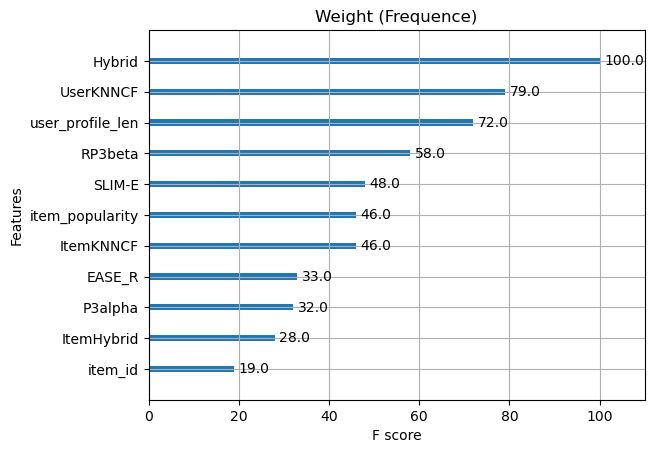

In [86]:
plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)')

In [87]:
X = test_dataframe

In [88]:
predictions = XGB_model.predict(X)
xgb_reranked = test_dataframe.copy()
xgb_reranked['rating_xgb'] = pd.Series(predictions, index=xgb_reranked.index)
xgb_reranked = xgb_reranked.sort_values(['user_id','rating_xgb'], ascending=[True, False])

In [89]:
user_recommendations = []

for user_id in tqdm(users_to_recommend):    
    user_recommendations.append(recommender_train_val.recommend(user_id, cutoff = 10))

100%|█████████████████████████████████████████████████████████████████████████████████| 9902/9902 [00:07<00:00, 1285.65it/s]


In [90]:
user_recommendations_boosted = []

for id in tqdm(users_to_recommend):
    user_recommendations_boosted.append(xgb_reranked.loc[xgb_reranked['user_id'] == id].item_id.values[:10].tolist())

100%|█████████████████████████████████████████████████████████████████████████████████| 9902/9902 [00:02<00:00, 3944.27it/s]


In [91]:
xgb_changed_item_count = 0

for i in range(len(user_recommendations)):
    default_items = user_recommendations[i]
    xgb_reranked_items = user_recommendations_boosted[i]
    
    xgb_new_items = list(set(xgb_reranked_items) - set(default_items))
    
    xgb_changed_item_count = xgb_changed_item_count + len(xgb_new_items)

n_users_to_recommend = len(users_to_recommend)
n_recommended_items = n_users_to_recommend * 10

print("XGBoost changed {} items, {:.2f}% of total".format(xgb_changed_item_count, xgb_changed_item_count/n_recommended_items * 100))

XGBoost changed 17706 items, 17.88% of total


In [92]:
print("Hybrid: {}".format(evaluate_recommender_MAP_from_rec_list(URM_test, user_recommendations, 10)))
print("XGBoost: {}".format(evaluate_recommender_MAP_from_rec_list(URM_test, user_recommendations_boosted, 10)))

Hybrid: 0.08221615178777185
XGBoost: 0.0818859774613329


In [93]:
res = evaluate_recommender_MAP_from_rec_list(URM_test, user_recommendations_boosted, 10)

if res > best_MAP:
    print("Improvement! Previous best MAP = {}， ".format(best_MAP) + "Now = {}".format(res))
    best_MAP = res

    best_n_est = n_estimators
    best_lr = learning_rate
    best_alpha = reg_alpha
    best_lambda = reg_lambda
    best_colsample = colsample_bytree
    best_gamma = gamma
    best_min_weight = min_child_weight
else:
    print("No improvement")

No improvement


In [94]:
print("Best parameters for MAP {}".format(best_MAP))
print("n_estimators = {}".format(best_n_est))
print("learning_rate = {}".format(best_lr))
print("reg_alpha = {}".format(best_alpha))
print("reg_lambda = {}".format(best_lambda))
print("colsample_bytree = {}".format(best_colsample))
print("gamma = {}".format(best_gamma))
print("min_child_weight = {}".format(best_min_weight))

Best parameters for MAP 0.08216308649087067
n_estimators = 685
learning_rate = 0.13859
reg_alpha = 35
reg_lambda = 0.34926
colsample_bytree = 0.831233
gamma = 3
min_child_weight = 7.0


## Tuning!

In [95]:
def objective(trial):
       
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.35)
    reg_alpha = trial.suggest_int("reg_alpha", 1, 50)
    reg_lambda = trial.suggest_float("reg_lambda", 0.05, 0.5)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.3, 1)
    gamma = trial.suggest_int("gamma", 2, 10)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 10)
    
    objective = "pairwise"
    use_user_profile = False
    random_seed = 42

    XGB_model = XGBRanker(objective='rank:{}'.format(objective),
        n_estimators = int(n_estimators),
        random_state = random_seed,
        learning_rate = learning_rate,
        reg_alpha = reg_alpha,
        reg_lambda = reg_lambda,
        max_depth = 3,
        max_leaves = 0,
        grow_policy = "depthwise",
        verbosity = 0, # 2 if self.verbose else 0,
        booster = "gbtree",
        enable_categorical = True,
        colsample_bytree = colsample_bytree,
        gamma = gamma,
        min_child_weight = min_child_weight,
        tree_method = "hist",  # Supported tree methods are `gpu_hist`, `approx`, and `hist`.
                      
    )

    XGB_model.fit(X_train_xgb,
          y_train,
          group=groups,
          verbose=True)

    X = test_dataframe

    predictions = XGB_model.predict(X)
    xgb_reranked = test_dataframe.copy()
    xgb_reranked['rating_xgb'] = pd.Series(predictions, index=xgb_reranked.index)
    xgb_reranked = xgb_reranked.sort_values(['user_id','rating_xgb'], ascending=[True, False])

    user_recommendations_boosted = []

    for id in tqdm(users_to_recommend):
        user_recommendations_boosted.append(xgb_reranked.loc[xgb_reranked['user_id'] == id].item_id.values[:10].tolist())

    res = evaluate_recommender_MAP_from_rec_list(URM_test, user_recommendations_boosted, 10)
       
    return res

In [96]:
best_params = {
    'n_estimators': 685,
    'learning_rate' : 0.13859,
    'reg_alpha' : 35,
    'reg_lambda' : 0.34926,
    'colsample_bytree' : 0.831233,
    'gamma' : 3,
    'min_child_weight' : 7.0,
}

In [97]:
study = op.create_study(direction="maximize")
study.enqueue_trial(best_params)
study.optimize(objective, n_trials=200)

[I 2024-01-10 22:25:32,909] A new study created in memory with name: no-name-24f76fec-b3e1-473d-a5e2-6a68e77471e9
100%|█████████████████████████████████████████████████████████████████████████████████| 9902/9902 [00:02<00:00, 3976.26it/s]
[I 2024-01-10 22:25:42,566] Trial 0 finished with value: 0.08216308649087067 and parameters: {'n_estimators': 685, 'learning_rate': 0.13859, 'reg_alpha': 35, 'reg_lambda': 0.34926, 'colsample_bytree': 0.831233, 'gamma': 3, 'min_child_weight': 7}. Best is trial 0 with value: 0.08216308649087067.
100%|█████████████████████████████████████████████████████████████████████████████████| 9902/9902 [00:02<00:00, 3887.07it/s]
[I 2024-01-10 22:25:52,408] Trial 1 finished with value: 0.08033773956873576 and parameters: {'n_estimators': 821, 'learning_rate': 0.22540781359041695, 'reg_alpha': 14, 'reg_lambda': 0.26386326574762564, 'colsample_bytree': 0.5438358517602198, 'gamma': 8, 'min_child_weight': 2}. Best is trial 0 with value: 0.08216308649087067.
100%|█████

100%|█████████████████████████████████████████████████████████████████████████████████| 9902/9902 [00:02<00:00, 3973.39it/s]
[I 2024-01-10 22:27:58,363] Trial 18 finished with value: 0.08169413973239052 and parameters: {'n_estimators': 991, 'learning_rate': 0.19196569507455177, 'reg_alpha': 25, 'reg_lambda': 0.491357450483471, 'colsample_bytree': 0.9146011626689515, 'gamma': 8, 'min_child_weight': 10}. Best is trial 0 with value: 0.08216308649087067.
100%|█████████████████████████████████████████████████████████████████████████████████| 9902/9902 [00:02<00:00, 4014.45it/s]
[I 2024-01-10 22:28:07,817] Trial 19 finished with value: 0.06779466149214669 and parameters: {'n_estimators': 518, 'learning_rate': 0.10084473118202711, 'reg_alpha': 1, 'reg_lambda': 0.32549204465421255, 'colsample_bytree': 0.6687668090478971, 'gamma': 3, 'min_child_weight': 7}. Best is trial 0 with value: 0.08216308649087067.
100%|█████████████████████████████████████████████████████████████████████████████████| 99

100%|█████████████████████████████████████████████████████████████████████████████████| 9902/9902 [00:02<00:00, 3909.16it/s]
[I 2024-01-10 22:34:52,422] Trial 36 finished with value: 0.0824167452810023 and parameters: {'n_estimators': 421, 'learning_rate': 0.150923190950744, 'reg_alpha': 45, 'reg_lambda': 0.29052579325440736, 'colsample_bytree': 0.9194734901265474, 'gamma': 2, 'min_child_weight': 7}. Best is trial 36 with value: 0.0824167452810023.
100%|█████████████████████████████████████████████████████████████████████████████████| 9902/9902 [00:02<00:00, 3856.47it/s]
[I 2024-01-10 22:35:00,347] Trial 37 finished with value: 0.0819379647809808 and parameters: {'n_estimators': 404, 'learning_rate': 0.15530440280566754, 'reg_alpha': 46, 'reg_lambda': 0.28745291836163483, 'colsample_bytree': 0.9188706107619138, 'gamma': 3, 'min_child_weight': 8}. Best is trial 36 with value: 0.0824167452810023.
100%|█████████████████████████████████████████████████████████████████████████████████| 9902

100%|█████████████████████████████████████████████████████████████████████████████████| 9902/9902 [00:02<00:00, 3885.77it/s]
[I 2024-01-10 22:40:32,845] Trial 54 finished with value: 0.08115502272166418 and parameters: {'n_estimators': 372, 'learning_rate': 0.2324834723371571, 'reg_alpha': 16, 'reg_lambda': 0.1845722485071036, 'colsample_bytree': 0.8140002668483651, 'gamma': 3, 'min_child_weight': 9}. Best is trial 36 with value: 0.0824167452810023.
100%|█████████████████████████████████████████████████████████████████████████████████| 9902/9902 [00:02<00:00, 3874.21it/s]
[I 2024-01-10 22:40:39,371] Trial 55 finished with value: 0.08177637558516869 and parameters: {'n_estimators': 301, 'learning_rate': 0.21337100784163957, 'reg_alpha': 48, 'reg_lambda': 0.3024597252182243, 'colsample_bytree': 0.9015693925819865, 'gamma': 6, 'min_child_weight': 8}. Best is trial 36 with value: 0.0824167452810023.
100%|█████████████████████████████████████████████████████████████████████████████████| 990

100%|█████████████████████████████████████████████████████████████████████████████████| 9902/9902 [00:02<00:00, 4007.24it/s]
[I 2024-01-10 22:43:18,347] Trial 72 finished with value: 0.08187058228907323 and parameters: {'n_estimators': 637, 'learning_rate': 0.1769140871366797, 'reg_alpha': 42, 'reg_lambda': 0.25477985874447634, 'colsample_bytree': 0.9034680082001774, 'gamma': 4, 'min_child_weight': 8}. Best is trial 65 with value: 0.08246429364346539.
100%|█████████████████████████████████████████████████████████████████████████████████| 9902/9902 [00:02<00:00, 3991.77it/s]
[I 2024-01-10 22:43:27,266] Trial 73 finished with value: 0.08215772545244199 and parameters: {'n_estimators': 675, 'learning_rate': 0.18897635117267272, 'reg_alpha': 49, 'reg_lambda': 0.19968461243634578, 'colsample_bytree': 0.8647770255642581, 'gamma': 2, 'min_child_weight': 6}. Best is trial 65 with value: 0.08246429364346539.
100%|█████████████████████████████████████████████████████████████████████████████████|

100%|█████████████████████████████████████████████████████████████████████████████████| 9902/9902 [00:03<00:00, 2954.04it/s]
[I 2024-01-10 22:45:59,095] Trial 90 finished with value: 0.08242455143614764 and parameters: {'n_estimators': 432, 'learning_rate': 0.22771025766282058, 'reg_alpha': 36, 'reg_lambda': 0.2169564986934891, 'colsample_bytree': 0.929269051753011, 'gamma': 2, 'min_child_weight': 4}. Best is trial 84 with value: 0.08261990774263998.
100%|█████████████████████████████████████████████████████████████████████████████████| 9902/9902 [00:03<00:00, 2834.51it/s]
[I 2024-01-10 22:46:09,147] Trial 91 finished with value: 0.08237544909119182 and parameters: {'n_estimators': 433, 'learning_rate': 0.21731887984792514, 'reg_alpha': 40, 'reg_lambda': 0.21067698597123766, 'colsample_bytree': 0.9427260832723434, 'gamma': 2, 'min_child_weight': 4}. Best is trial 84 with value: 0.08261990774263998.
100%|█████████████████████████████████████████████████████████████████████████████████| 

100%|█████████████████████████████████████████████████████████████████████████████████| 9902/9902 [00:03<00:00, 2615.94it/s]
[I 2024-01-10 22:48:54,232] Trial 108 finished with value: 0.08243774682554171 and parameters: {'n_estimators': 297, 'learning_rate': 0.2456355223856866, 'reg_alpha': 31, 'reg_lambda': 0.20757463480278204, 'colsample_bytree': 0.8041155652076192, 'gamma': 2, 'min_child_weight': 5}. Best is trial 105 with value: 0.08269042456652145.
100%|█████████████████████████████████████████████████████████████████████████████████| 9902/9902 [00:03<00:00, 2712.27it/s]
[I 2024-01-10 22:49:02,480] Trial 109 finished with value: 0.08230007764044263 and parameters: {'n_estimators': 301, 'learning_rate': 0.2508897398692524, 'reg_alpha': 31, 'reg_lambda': 0.2455173266965192, 'colsample_bytree': 0.7902100719555238, 'gamma': 2, 'min_child_weight': 5}. Best is trial 105 with value: 0.08269042456652145.
100%|████████████████████████████████████████████████████████████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 9902/9902 [00:03<00:00, 2973.46it/s]
[I 2024-01-10 22:51:35,797] Trial 126 finished with value: 0.08238051923399548 and parameters: {'n_estimators': 352, 'learning_rate': 0.23891734660484854, 'reg_alpha': 29, 'reg_lambda': 0.20959043755589968, 'colsample_bytree': 0.929359888261512, 'gamma': 2, 'min_child_weight': 4}. Best is trial 105 with value: 0.08269042456652145.
100%|█████████████████████████████████████████████████████████████████████████████████| 9902/9902 [00:03<00:00, 2646.74it/s]
[I 2024-01-10 22:51:44,585] Trial 127 finished with value: 0.08229310354029298 and parameters: {'n_estimators': 323, 'learning_rate': 0.2446100336318519, 'reg_alpha': 32, 'reg_lambda': 0.23106220276117911, 'colsample_bytree': 0.8981996507913873, 'gamma': 2, 'min_child_weight': 4}. Best is trial 105 with value: 0.08269042456652145.
100%|███████████████████████████████████████████████████████████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 9902/9902 [00:03<00:00, 2773.72it/s]
[I 2024-01-10 22:55:00,160] Trial 144 finished with value: 0.0822777203429078 and parameters: {'n_estimators': 501, 'learning_rate': 0.24478065924666112, 'reg_alpha': 32, 'reg_lambda': 0.20306928249245687, 'colsample_bytree': 0.8076765433067519, 'gamma': 2, 'min_child_weight': 2}. Best is trial 105 with value: 0.08269042456652145.
100%|█████████████████████████████████████████████████████████████████████████████████| 9902/9902 [00:02<00:00, 3442.18it/s]
[I 2024-01-10 22:55:10,968] Trial 145 finished with value: 0.08248841808580201 and parameters: {'n_estimators': 446, 'learning_rate': 0.2508267969858416, 'reg_alpha': 37, 'reg_lambda': 0.21230806653076528, 'colsample_bytree': 0.8562573888537314, 'gamma': 2, 'min_child_weight': 4}. Best is trial 105 with value: 0.08269042456652145.
100%|███████████████████████████████████████████████████████████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 9902/9902 [00:02<00:00, 3374.31it/s]
[I 2024-01-10 22:57:54,018] Trial 162 finished with value: 0.0819612918843261 and parameters: {'n_estimators': 317, 'learning_rate': 0.26397047914257477, 'reg_alpha': 38, 'reg_lambda': 0.23475596558897419, 'colsample_bytree': 0.9369074280455885, 'gamma': 2, 'min_child_weight': 3}. Best is trial 105 with value: 0.08269042456652145.
100%|█████████████████████████████████████████████████████████████████████████████████| 9902/9902 [00:03<00:00, 2547.89it/s]
[I 2024-01-10 22:58:03,941] Trial 163 finished with value: 0.08236570141607956 and parameters: {'n_estimators': 380, 'learning_rate': 0.2590970475025401, 'reg_alpha': 40, 'reg_lambda': 0.19773399675407105, 'colsample_bytree': 0.90373273501399, 'gamma': 2, 'min_child_weight': 4}. Best is trial 105 with value: 0.08269042456652145.
100%|█████████████████████████████████████████████████████████████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 9902/9902 [00:02<00:00, 3447.91it/s]
[I 2024-01-10 23:00:45,072] Trial 180 finished with value: 0.08222139031035247 and parameters: {'n_estimators': 413, 'learning_rate': 0.2377367800106514, 'reg_alpha': 36, 'reg_lambda': 0.24422196413825029, 'colsample_bytree': 0.7842252047396091, 'gamma': 2, 'min_child_weight': 3}. Best is trial 105 with value: 0.08269042456652145.
100%|█████████████████████████████████████████████████████████████████████████████████| 9902/9902 [00:02<00:00, 3435.46it/s]
[I 2024-01-10 23:01:01,465] Trial 181 finished with value: 0.08164656748378993 and parameters: {'n_estimators': 938, 'learning_rate': 0.18148119178705807, 'reg_alpha': 45, 'reg_lambda': 0.2064913527587423, 'colsample_bytree': 0.9494675593464026, 'gamma': 2, 'min_child_weight': 7}. Best is trial 105 with value: 0.08269042456652145.
100%|███████████████████████████████████████████████████████████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 9902/9902 [00:03<00:00, 2515.50it/s]
[I 2024-01-10 23:04:33,521] Trial 198 finished with value: 0.08225293705983014 and parameters: {'n_estimators': 314, 'learning_rate': 0.11132871585314807, 'reg_alpha': 39, 'reg_lambda': 0.1906538353739659, 'colsample_bytree': 0.9118572962077, 'gamma': 2, 'min_child_weight': 5}. Best is trial 105 with value: 0.08269042456652145.
100%|█████████████████████████████████████████████████████████████████████████████████| 9902/9902 [00:03<00:00, 3113.29it/s]
[I 2024-01-10 23:04:44,391] Trial 199 finished with value: 0.0825157048173892 and parameters: {'n_estimators': 357, 'learning_rate': 0.09929733456096586, 'reg_alpha': 37, 'reg_lambda': 0.20129349398958982, 'colsample_bytree': 0.9007430376255577, 'gamma': 2, 'min_child_weight': 5}. Best is trial 105 with value: 0.08269042456652145.


In [ ]:
study.best_params

In [ ]:
0.08219
105 0.08278

## Try to make submission

In [ ]:
# Open the submission sample file
submission_sample = open('Input/data_target_users_test.csv', 'r')
type(submission_sample)

In [ ]:
# Read the dataframe
target = pd.read_csv(filepath_or_buffer=submission_sample)
target

In [ ]:
def write_recommendations(recommender):
    recommendations = 'user_id,item_list'
    f = open("Output/NoXGB25.csv", "w")

    for id in tqdm(target['user_id']):
        recommendations_per_user = recommender.recommend(user_id_array=id, remove_seen_flag=True, cutoff=10)

        recommendation_string = str(id) + ','

        for rec in recommendations_per_user:
            recommendation_string = recommendation_string + str(rec) + ' '

        recommendation_string = recommendation_string[:-1]
        recommendations = recommendations + '\n' + recommendation_string

    f.write(recommendations)
    f.close()

In [ ]:
write_recommendations(recommender_all)

## Build models on the complete URM

In [98]:
slime_all = MultiThreadSLIM_SLIMElasticNetRecommender(URM_all)
slime_all.fit(l1_ratio=0.0702, alpha=0.000722, topK=692)
slime_all.save_model("Final/", "slime_all.zip")

SLIMElasticNetRecommender: URM Detected 387 ( 3.0%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 126 ( 0.6%) items with no interactions.


100%|███████████████████████████████████████████████████████████████████████████████▉| 22344/22348 [02:49<00:00, 131.45it/s]


SLIMElasticNetRecommender: Saving model in file 'Final/slime_all.zip'
SLIMElasticNetRecommender: Saving complete


In [99]:
itemknncf_all = ItemKNNCFRecommender(URM_all)
itemknncf_all.fit(shrink=15.47563, topK=12, similarity='dice')
itemknncf_all.save_model("Final/", "itemknncf_all.zip")

ItemKNNCFRecommender: URM Detected 387 ( 3.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 126 ( 0.6%) items with no interactions.
Similarity column 22348 (100.0%), 9822.89 column/sec. Elapsed time 2.28 sec
ItemKNNCFRecommender: Saving model in file 'Final/itemknncf_all.zip'
ItemKNNCFRecommender: Saving complete


In [100]:
p3alpha_all = P3alphaRecommender(URM_all)
p3alpha_all.fit(topK=35, alpha=0.210046, implicit=True, normalize_similarity=True)
p3alpha_all.save_model("Final/", "p3alpha_all.zip")

P3alphaRecommender: URM Detected 387 ( 3.0%) users with no interactions.
P3alphaRecommender: URM Detected 126 ( 0.6%) items with no interactions.
P3alphaRecommender: Similarity column 22348 (100.0%), 4304.68 column/sec. Elapsed time 5.19 sec
P3alphaRecommender: Saving model in file 'Final/p3alpha_all.zip'
P3alphaRecommender: Saving complete


In [101]:
rp3beta_all = RP3betaRecommender(URM_all)
rp3beta_all.fit(topK=25, alpha=0.253519, beta=0.209538, implicit=True, normalize_similarity=True)
rp3beta_all.save_model("Final/", "rp3beta_all.zip")

RP3betaRecommender: URM Detected 387 ( 3.0%) users with no interactions.
RP3betaRecommender: URM Detected 126 ( 0.6%) items with no interactions.
RP3betaRecommender: Similarity column 22348 (100.0%), 4899.11 column/sec. Elapsed time 4.56 sec
RP3betaRecommender: Saving model in file 'Final/rp3beta_all.zip'
RP3betaRecommender: Saving complete


In [103]:
ease_all = EASE_R_Recommender(URM_all)
ease_all.fit(topK=29, l2_norm=19)
ease_all.save_model("Final/", "ease_all.zip")

EASE_R_Recommender: URM Detected 387 ( 3.0%) users with no interactions.
EASE_R_Recommender: URM Detected 126 ( 0.6%) items with no interactions.
EASE_R_Recommender: Fitting model... 
EASE_R_Recommender: Fitting model... done in 1.81 min
EASE_R_Recommender: Saving model in file 'Final/ease_all.zip'
EASE_R_Recommender: Saving complete


In [ ]:
userknncf_all = UserKNNCFRecommender(URM_all)
userknncf_all.fit(shrink=1.432797, topK=329, feature_weighting="TF-IDF")

In [102]:
sim1 = Compute_Similarity(URM_all, shrink = 0, topK = 5, similarity = 'cosine').compute_similarity()
sim2 = Compute_Similarity(URM_all, shrink = 0.5, topK = 65, similarity = 'cosine').compute_similarity()
itemhybrid_all = ItemKNNSimilarityHybridRecommender(URM_all, sim1, sim2)
itemhybrid_all.fit(topK = 70, alpha = 0.65)
itemhybrid_all.save_model("Final/", "itemhybrid_all.zip")

Similarity column 22348 (100.0%), 5552.34 column/sec. Elapsed time 4.02 sec
Similarity column 22348 (100.0%), 5984.45 column/sec. Elapsed time 3.73 sec
ItemKNNSimilarityHybridRecommender: URM Detected 387 ( 3.0%) users with no interactions.
ItemKNNSimilarityHybridRecommender: URM Detected 126 ( 0.6%) items with no interactions.
ItemKNNSimilarityHybridRecommender: Saving model in file 'Final/itemhybrid_all.zip'
ItemKNNSimilarityHybridRecommender: Saving complete


In [ ]:
recommender_all = ScoresHybridRecommender3(URM_all, slime_all, itemhybrid_all, rp3beta_all)
recommender_all.fit(alpha=0.7, beta=0.05)

In [ ]:
other_algorithms_all = {
    "Hybrid": recommender_all,
    "ItemKNNCF": itemknncf_all,
    "P3alpha": p3alpha_all,
    "RP3beta": rp3beta_all,
    "SLIM-E": slime_all,
    "EASE_R": ease_all,
    "UserKNNCF": userknncf_all,
    "ItemHybrid": itemhybrid_all,
}

In [ ]:
user_recommendations_items = []
user_recommendations_user_id = []

for id in tqdm(target['user_id']):
    recommendations = recommender_all.recommend(user_id_array=id, remove_seen_flag=True, cutoff=cutoff)
    
    user_recommendations_items.extend(recommendations)
    user_recommendations_user_id.extend([id]*len(recommendations))

In [ ]:
test_dataframe = pd.DataFrame({"user_id":user_recommendations_user_id, "item_id":user_recommendations_items})

In [ ]:
test_dataframe = test_dataframe.set_index('user_id')

for user_id in tqdm(target['user_id']):
    for rec_label, rec_instance in other_algorithms_all.items():
        
        item_list = test_dataframe.loc[user_id, "item_id"].values.tolist()
        
        all_item_scores = rec_instance._compute_item_score([user_id], items_to_compute = item_list)

        test_dataframe.loc[user_id, rec_label] = all_item_scores[0, item_list] 

test_dataframe = test_dataframe.reset_index()
test_dataframe = test_dataframe.rename(columns = {"index": "user_id"})

In [ ]:
item_popularity = np.ediff1d(sps.csc_matrix(URM_all).indptr)
test_dataframe['item_popularity'] = item_popularity[test_dataframe["item_id"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_all).indptr)
test_dataframe['user_profile_len'] = user_popularity[test_dataframe["user_id"].values.astype(int)]

test_dataframe

In [ ]:
X = test_dataframe

In [ ]:
predictions = XGB_model.predict(X)
predictions

In [ ]:
reranked_dataframe = test_dataframe.copy()
reranked_dataframe['rating_xgb'] = pd.Series(predictions, index=reranked_dataframe.index)
reranked_dataframe

In [ ]:
reranked_dataframe = reranked_dataframe.sort_values(['user_id','rating_xgb'], ascending=[True, False])
reranked_dataframe

In [ ]:
def write_reranked_recommendations():
    recommendations = 'user_id,item_list'
    f = open("Output/NewXGB.csv", "w")

    for id in tqdm(target['user_id']):
        recommendations_per_user = reranked_dataframe.loc[reranked_dataframe['user_id'] == id].item_id.values[:10]

        recommendation_string = str(id) + ','

        for rec in recommendations_per_user:
            recommendation_string = recommendation_string + str(rec) + ' '

        recommendation_string = recommendation_string[:-1]
        recommendations = recommendations + '\n' + recommendation_string

    f.write(recommendations)
    f.close()

In [ ]:
write_reranked_recommendations()

In [ ]:
result_hybrid, _ = evaluator_test.evaluateRecommender(recommender_train)
result_elastic, _ = evaluator_test.evaluateRecommender(slime_train)
result_rp3b, _ = evaluator_test.evaluateRecommender(rp3beta_train)
result_itemknncf, _ = evaluator_test.evaluateRecommender(itemknncf_train)
result_itemhybrid, _ = evaluator_test.evaluateRecommender(itemhybrid_train)
result_userKnn, _ = evaluator_test.evaluateRecommender(userknncf_train)
result_p3a, _ = evaluator_test.evaluateRecommender(p3alpha_train)
result_ease, _ = evaluator_test.evaluateRecommender(ease_train)


print("Hybrid: {}".format(result_hybrid['MAP'].item()))
print("SLIM Elastic: {}".format(result_elastic['MAP'].item()))
print("RP3Beta: {}".format(result_rp3b['MAP'].item()))
print("ItemKNN_CF: {}".format(result_itemknncf['MAP'].item()))
print("ItemKNN_hybrid: {}".format(result_itemhybrid['MAP'].item()))
print("UserKNN: {}".format(result_userKnn['MAP'].item()))
print("P3Alpha: {}".format(result_p3a['MAP'].item()))
print("EASE: {}".format(result_ease['MAP'].item()))